# Spain gross income distribution per person

In this notebook, I will explore an application of the lognormal probability distribution.

  The data of gross income per person per year in euros for Spain is fitted to a [lognormal probability distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). A lognormal model has been successfully used in economics to model the distribution of income for up to approximately 95% of a country's population. 
  
To understand the method used to derive the parameters of the distribution, one should know what is:
  - Normal distribution.
  - Standard normal distribution.
  - Lognormal distribution.
  - Quantile.
  - Logarithms and exponents.
  - Basic optimization.
  
## Data Source
1. I downloaded the data from Spain's [National Institute of Statistics](https://www.ine.es/index.htm) (INE—Instituto Nacional de Estadística), specifically in CSV format, from the following link (https://ine.es/jaxiT3/Tabla.htm?t=28191&L=0). The CSV was named by default 28191.csv, but I renamed it to spain_salary_distribution.csv to store it locally on my computer.
2. I also downloaded the [publicly available data provided by AEAT](https://sede.agenciatributaria.gob.es/AEAT/Contenidos_Comunes/La_Agencia_Tributaria/Estadisticas/Publicaciones/sites/irpf/2022/jrubik592444a7f926d31e5daa6e1d35549f0aaf47969e.html) (Agencia Estatal de la Administración Tributaria) about gross yearly income in euros per person (available up to 2022) to enrich the statistics further.


I also uploaded the data after translating headers to English to Kaggle: https://www.kaggle.com/jtljtl/spain-salary-distribution

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

In [2]:
df = pd.read_csv("spain_salary_distribution.csv",sep=';',encoding='iso-8859-1')

# Convert attribute "Total" from Object data type to float
df["Total"] = df["Total"].apply(lambda x: float(x.replace('.','').replace(',','.')))

# Map statistics in words to numbers
qmap = {
    "Percentil 10": 0.1,
    "Cuartil inferior": 0.25,
    "Mediana": 0.5,
    "Cuartil superior": 0.75,
    "Percentil 90": 0.9,
    "Media": np.nan
}

# Translate headers
col_names = {
    "Sexo": "gender",
    "Comunidades autónomas": "state",
    "Medidas y percentiles": "statistic",
    "Periodo": "year",
    "Total": "gross_income_euros",
}

# Translate gender
gmap = {
    "Mujeres": "female",
    "Hombres": "male",
    "Ambos sexos" : "both"
}

# Translate statistics
smap = {
    "Cuartil superior" : "upper_quartile",
    "Cuartil inferior" : "lower_quartile",
    "Mediana" : "median",
    "Percentil 90" : "90th_percentile",
    "Percentil 10" : "10th_percentile",
    "Media" : "mean"
}


df.rename(columns=col_names, inplace=True)

df["gender"] = df["gender"].apply(lambda s: gmap.get(s))

df["percentile"] = df["statistic"].apply(lambda s: qmap.get(s))

df["statistic"] = df["statistic"].apply(lambda s: smap.get(s))

df["state"] = df["state"].apply(lambda s: 'nationwide' if s == 'Total Nacional' else s)

def filter_df(state, gender,statistic):
    f1 = df.loc[:,"state"] == state
    f2 = df.loc[:,"gender"] == gender
    f3 = df.loc[:,"statistic"] == statistic
    return f1 & f2 & f3

We are given statistics about the gross income in euros (Total), per person for Spain. We have in "Medias y percentiles":
- The 10th percentile (Percentil 10).
- The lower quartile (Cuartil inferior).
- The median (Mediana).
- The mean (Media).
- The upper quartile (Cuartil superior).
- The 90th percentile (Percentil 90).

These statistics are seggregated by:

- Gender (Sexo).
- Year (Periodo).
- State (Comunidades autónomas).

In this notebook, I will just explore total national incomes, but the analysis could be extended to gender, year, and state.

In [3]:
df.sample(10)

,gender,state,statistic,year,gross_income_euros,percentile
4733,male,País Vasco,median,2014,28799.94,0.50
2268,female,Castilla y León,10th_percentile,2019,6765.51,0.10
3888,male,Castilla y León,10th_percentile,2019,12453.04,0.10
321,both,"Asturias, Principado de",median,2016,20081.25,0.50
3131,female,País Vasco,upper_quartile,2011,30201.90,0.75
1205,both,"Madrid, Comunidad de",lower_quartile,2017,14697.30,0.25
3792,male,Cantabria,mean,2010,23924.51,NaN
2988,female,"Navarra, Comunidad Foral de",10th_percentile,2019,8195.45,0.10
2148,female,Canarias,90th_percentile,2019,37036.45,0.90
3824,male,Cantabria,lower_quartile,2008,15546.39,0.25


In [4]:
# https://sede.agenciatributaria.gob.es/AEAT/Contenidos_Comunes/La_Agencia_Tributaria/Estadisticas/Publicaciones/sites/irpf/2022/jrubik592444a7f926d31e5daa6e1d35549f0aaf47969e.html
# https://www.bankinter.com/blog/finanzas-personales/sueldo-mas-altos-por-paises

data_aeat = {
    "pmf": np.array([5.61+6.18+13.22, 10.10, 21.02, 17.36, 21.27, 4.53, 0.63])/100,
    "gross_income_euros": [6_000, 12_000, 21_000, 30_000, 60_000, 150_000, 601_000]
}
data_aeat["cdf"] = np.cumsum(data_aeat["pmf"])

In [5]:
data_aeat

{'pmf': array([0.2501, 0.101 , 0.2102, 0.1736, 0.2127, 0.0453, 0.0063]),
 'gross_income_euros': [6000, 12000, 21000, 30000, 60000, 150000, 601000],
 'cdf': array([0.2501, 0.3511, 0.5613, 0.7349, 0.9476, 0.9929, 0.9992])}

In [6]:
df.loc[filter_df("nationwide", "both","lower_quartile")&(df.year==2022),:]

,gender,state,statistic,year,gross_income_euros,percentile
30,both,nationwide,lower_quartile,2022,15913.52,0.25


In [7]:
df.loc[filter_df("nationwide", "both","median")&(df.year==2022),:]

,gender,state,statistic,year,gross_income_euros,percentile
45,both,nationwide,median,2022,22383.11,0.5


In [8]:
df.loc[filter_df("nationwide", "both","upper_quartile")&(df.year==2022),:]

,gender,state,statistic,year,gross_income_euros,percentile
60,both,nationwide,upper_quartile,2022,33561.62,0.75


There are discrepancies in the lower percentiles of the data provided by AEAT and  INE. For example, the INE data states that 25% of the working population's yearly gross income is 15913.52€. In contrast, AEAT data says that it is  6000€. This difference diminishes between datasets as the percentiles increase. For example, for the median, the INE data says that it is  22383.11€, and the AEAT says that the percentile 56th is 21000€. Then,  for the upper quartile (75th percentile), the INE data provides a value of 33561.62€, whereas the AEAT value for the 73th percentile is 30000€. So, the difference between values on the two datasets becomes smaller as the percentiles increase.

While the reasons for these discrepancies are not immediately clear, the observation is unmistakable. Therefore, I have decided to use the upper percentiles provided by AEAT to enhance the INE data, while disregarding the lower percentiles from AEAT. My hypothesis is that lower-paying jobs may involve a portion of the total pay being made in cash, which is often not  declared for tax purposes. This could explain why the AEAT data does not accurately represent the lower percentiles of the income distribution. This is an  educated guess based on estimates of the Spanish economy, which suggest that between  20 and 25% of the total economy is not declared for tax purposes.

My second hypothesis to justify the convergence of percentile values on upper percentiles is that higher-paying jobs make it harder or rarer to use cash as payment. Thus, most of the payments made to employees in higher-paying jobs are likely to be reported accurately to AEAT. As a consequence, I decided to enrich the INE data using only the top three percentiles provided by AEAT data: p94.7, p99.29, and p99.92.

## Data visualization

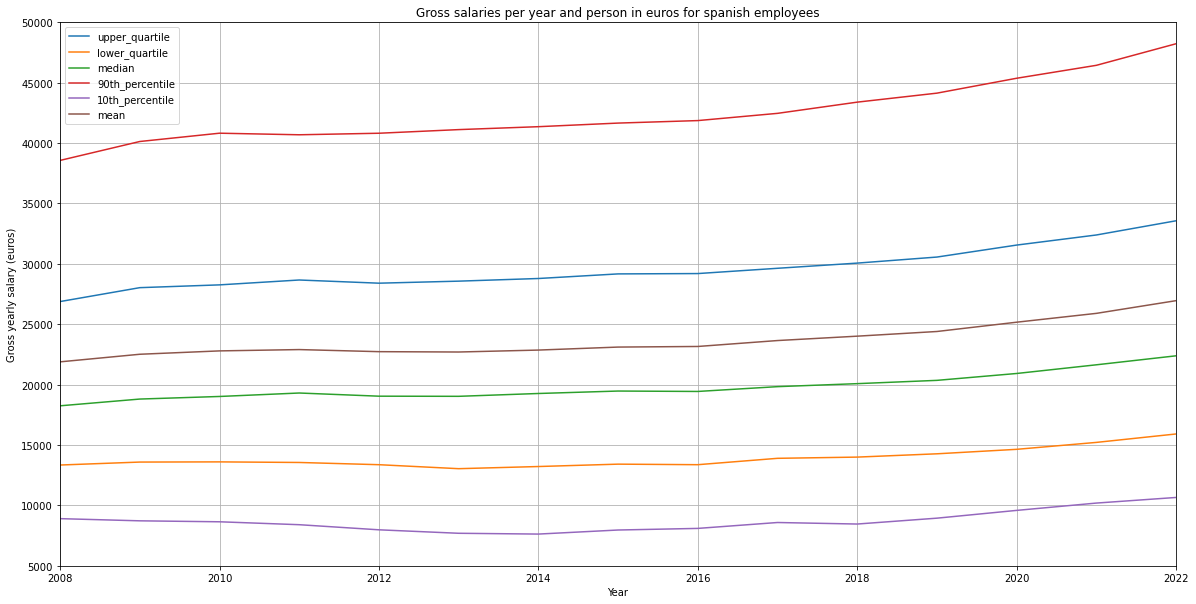

In [9]:
fig = plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([2008,2022])
axes.set_ylim([5000,50000])

for s in smap.values():
    f = filter_df("nationwide","both",statistic=s)
    plt.plot(df.loc[f,"year"], df.loc[f,"gross_income_euros"],label=s)

plt.title('Gross salaries per year and person in euros for spanish employees')
plt.legend(loc='upper left')
plt.grid()
plt.ylabel('Gross yearly salary (euros)')
plt.xlabel('Year')
plt.show()

## Fitting data to a lognormal distribution


$ X \sim Lognorm(\mu, \sigma^2) $

I suppose that the income is distributed lognormally between the 10th and 90th percentiles. To find the parameters of the distribution, I use the analytic formula for the median of the distribution:

$$ median = e^\mu \implies \mu = log(median) \qquad (1)$$

For the standard deviation ($\sigma$), we know since it is lognormal distribution that:

$$ q = P(X \leq x_q) = \Phi\left(Z \leq \frac{log(x_q) - \mu}{\sigma}\right) \qquad (2)$$

The quantiles given and the logarithm of their respective values follow a normal distribution, so we can standardize the income random variable and find the corresponding values of the standard normal random variable that corresponds to those quantiles.

In [10]:
f = (df.year==2022)&(df.gender=="both")&(df.state=="nationwide")&(df.statistic!="mean")
quantiles_values = list(df.loc[f,"gross_income_euros"].values)
# AEAT data below: 60k, 150k and 601k
quantiles_values.append(60_000.0) 
# quantiles_values.append(150_000)
# quantiles_values.append(601_000)
quantiles_values

[10657.37, 15913.52, 22383.11, 33561.62, 48217.21, 60000.0]

In [11]:
quantiles = [0.1,0.25,0.5,0.75,0.9]
quantiles += [0.9476] # 0.9929] # , 0.9992] # AEAT data
z = stats.norm.ppf(quantiles)
z

array([-1.28155157, -0.67448975,  0.        ,  0.67448975,  1.28155157,
        1.62201564])

Now associate values of the income to those quantiles, which we can do visually by looking at the plot above so, approximately:


In [12]:
xq = quantiles_values

Since we know $\mu$ by (1), $X_q$ and $q$ by data, and $Z$ by calculation, we can compute sigma by minimizing the squared error in (2):

$$ Error(\sigma) = \sum_i^n \left(z_i - \frac{log(x_{qi}) - \mu}{\sigma} \right)^2 \qquad (3)$$

The main caveat of this approach is that we only have five data points: p10, p25, p50, p75 and p90.

In [13]:
# scipy parametrization. mu calculated as in (1)
_median = df.loc[(df.year==2022)&filter_df("nationwide","both","median"),"gross_income_euros"].values[0]
loc = np.log(_median) # (1): mu = log(median)

# Define the error function as in (3)
error = lambda sigma: sum((zi - (np.log(xqi)-loc)/sigma)**2 for zi,xqi in zip(z,xq))

# Initial guess as in (4)
_mean = df.loc[(df.year==2022)&filter_df("nationwide","both","mean"),"gross_income_euros"].values[0]
sigma = lambda mean, mu: (2*(np.log(mean)-mu))**0.5
x0 = sigma(_mean, loc)

# Minimize it. res.x contains the value of the parameter
res = minimize(error, x0=x0, method='Nelder-Mead', tol=1e-6)
res.x[0]

0.5925722189181554

$x0$ is an estimate of the parameter being minimized. I set it by using the formula:

$$ mean = exp\left(\mu + \frac{\sigma^2}{2}\right) \implies \sigma^2 = 2log(mean) - 2\mu \qquad (4)$$

Since we know the mean (data) and $\mu$ we can use (4) to find a educated guess of $\sigma$:

In [14]:
sigma(_mean, loc), res.x[0]

(0.6093188170202187, 0.5925722189181554)

In [15]:
error(res.x[0]), error(sigma(_mean, loc))

(0.012646769747491265, 0.017793262577768153)

The error using the minization method is smaller than the error using only the initial guess based on analytical formulas for the lognormal distribution. Still, the optimized parameter is quite close to the initial guess.

This is one of the many possible ways of estimating the distribution's parameters. I used this method since we were given quantiles instead of sampled data. The idea is to fit the quantiles to the CDF of the lognormal distribution.

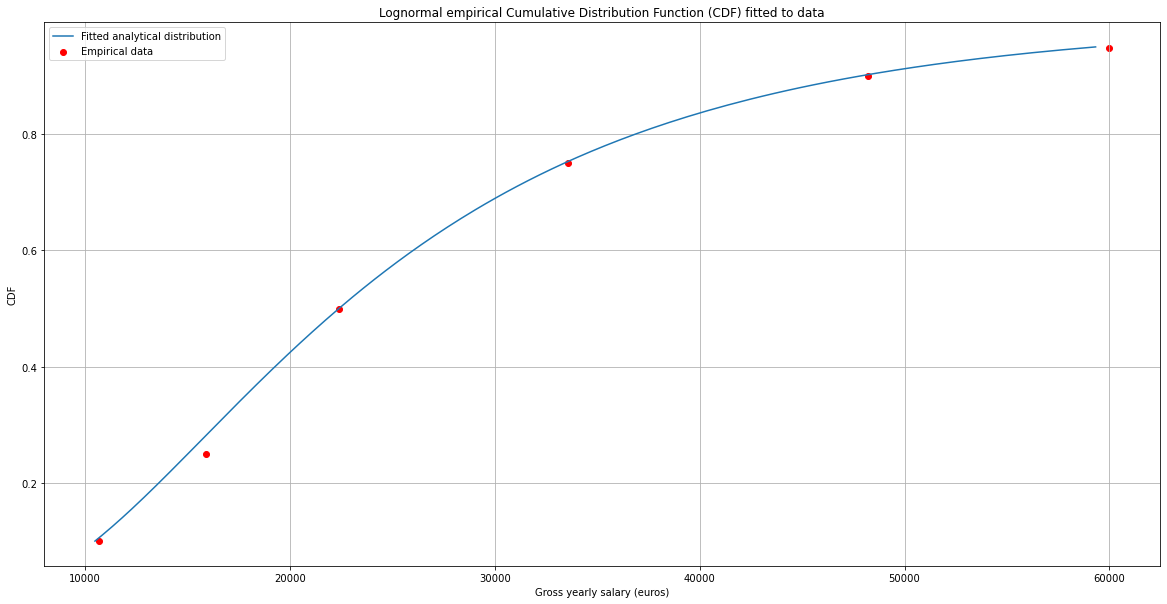

In [16]:
# Generate samples from the calculated distribution to make plots
q = np.arange(0.1, 0.951, 0.005)
# docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
x = stats.lognorm.ppf(q, s=res.x[0], scale=_median) # s=sigma(_mean, loc)

fig = plt.figure(figsize=(20,10))
axes = plt.gca()

plt.scatter(xq, quantiles, color="red", label="Empirical data")
plt.plot(x, q, label="Fitted analytical distribution")

plt.title('Lognormal empirical Cumulative Distribution Function (CDF) fitted to data')
plt.grid()
plt.xlabel('Gross yearly salary (euros)')
plt.legend(loc="upper left")
plt.ylabel('CDF')
plt.show()

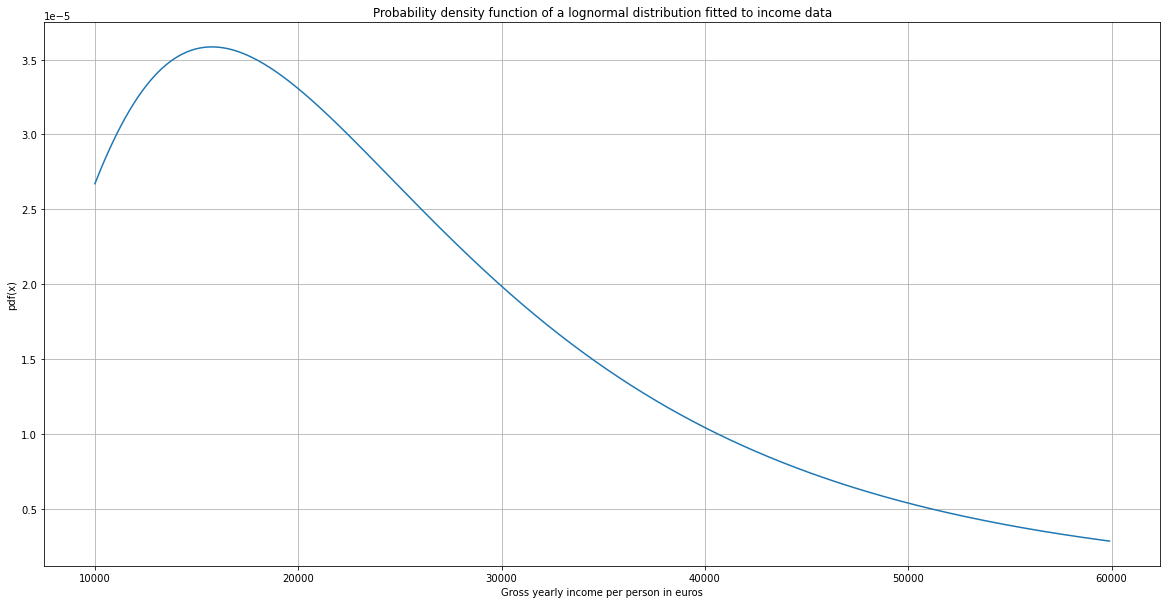

In [17]:
xinc = np.arange(10_000,60_000,100)
fig = plt.figure(figsize=(20,10))
plt.plot(xinc, stats.lognorm.pdf(xinc, s=res.x, scale=_median)) # s=sigma(_mean, loc)
plt.xlabel('Gross yearly income per person in euros')
plt.ylabel('pdf(x)')
plt.grid()
plt.title('Probability density function of a lognormal distribution fitted to income data')
plt.show()

As can be seen from the plot of the empirical cumulative distribution function, the lognormal distribution fits the data accurately. Now that we have the distribution and its parameters we can compute any value and its percentiles. The computation can be useful to estimate how much can the country expect to collect in taxes from this population range, or to assess where a person lies in the salary distribution, which could be useful to stablish public aid programs. Notice also that the mode is around 16000 euros (in 2022), which means that most frequent value for a person's income in Spain is approximately 1170 euros per month after taxes payed in twelve payments.

## Top 2.5% incomes

From wikipedia:
> In economics, there is evidence that the income of 97%–99% of the population is distributed log-normally. (The distribution of higher-income individuals follows a Pareto distribution).

Source: Wataru, Souma (2002-02-22). "Physics of Personal Income". In Takayasu, Hideki (ed.). Empirical Science of Financial Fluctuations: The Advent of Econophysics. Springer. arXiv:cond-mat/0202388. doi:10.1007/978-4-431-66993-7

I tried fitting the lognormal distribution with the upper percentiles p99.29 (150k€) and p99.92 (601k€). Still, the fit was obviously incorrect for percentiles higher than p97. The fit would increase its error on lower percentiles while underestimating upper percentiles. The results indicate that the lognormal distribution is limited in this case to p97. So, I will use a parato distribution instead to model the top 2.5%, as the quote above suggests. 

There's a philosophical implication hidden in the fact that the income distribution as an employee can't be modeled only by one probability distribution. The income of 97% of the working population seems to be governed by a different law than the remaining 3%. This implies that the top 3% of earners must be doing something different than the rest to get, stay, and get to higher percentiles. It signals that they have found mechanisms by which they can accelerate their income growth over time, methods that are fundamentally different from the ones the rest of the population is using. Otherwise, I would expect one distribution to model all the income brackets.

The Cumulative Distribution Function (CDF) of a pareto distribution is modeled by: $$ CDF(x) = {\displaystyle 1-\left({\frac {x_{\mathrm {m} }}{x}}\right)^{\alpha }} $$ where Alpha and Xm are the distribution parameters. I will use the few quantiles I got from AEAT to find those parameters.

In [18]:
# AEAT data
pareto_x = [60_000.0, 150_000.0, 601_000.0]
pareto_q = [0.9476, 0.9929, 0.9992]

# first poin estimated with lognormal, hypothesis: we can extrapolate with lognormal from p95 to p97
min_q = 0.975 # Educated guess based on the paper "Physics of Personal Income" cited above
xm = round(stats.lognorm.ppf(min_q, s=res.x[0], scale=_median),0)
pareto_x = [xm, 150_000.0, 601_000.0]
pareto_q = [min_q, 0.9929, 0.9992]

# Normalizing the top percentiles >=95th to be a new entire distribution
xm = pareto_x[0] # The minimum value x can take
pareto_range = 1 - pareto_q[0]
pareto_q = [(q - pareto_q[0])/pareto_range for q in pareto_q]

def pareto_error_func(alpha):
    return sum((1 - (xm/px)**alpha - pq)**2 for pq, px in zip(pareto_q, pareto_x))

def pareto_error_func_v2(alpha):
    return sum((xm*(1-pq)**(-1/alpha) - px)**2 for pq, px in zip(pareto_q, pareto_x))

res_pareto = minimize(pareto_error_func, x0=2, method='Nelder-Mead', tol=1e-6)
res_pareto_v2 = minimize(pareto_error_func_v2, x0=2, method='Nelder-Mead', tol=1e-6)
res_pareto, res_pareto_v2

( final_simplex: (array([[1.69275742],
        [1.69275818]]), array([2.4525859e-05, 2.4525859e-05]))
            fun: 2.4525859025458107e-05
        message: 'Optimization terminated successfully.'
           nfev: 42
            nit: 21
         status: 0
        success: True
              x: array([1.69275742]),
  final_simplex: (array([[1.61751359],
        [1.61751359]]), array([32807442.1303641 , 32807442.13036502]))
            fun: 32807442.130364098
        message: 'Optimization terminated successfully.'
           nfev: 60
            nit: 30
         status: 0
        success: True
              x: array([1.61751359]))

In [19]:
alpha1, alpha2 = res_pareto.x[0], res_pareto_v2.x[0]
xm, alpha1, alpha2

(71502.0, 1.692757415771484, 1.6175135895609851)

In [20]:
stats.pareto.ppf(pareto_q, b=alpha2, scale=xm), pareto_q, pareto_x

(array([ 71502.        , 155702.19609728, 600459.25810363]),
 [0.0, 0.7160000000000004, 0.9679999999999991],
 [71502.0, 150000.0, 601000.0])

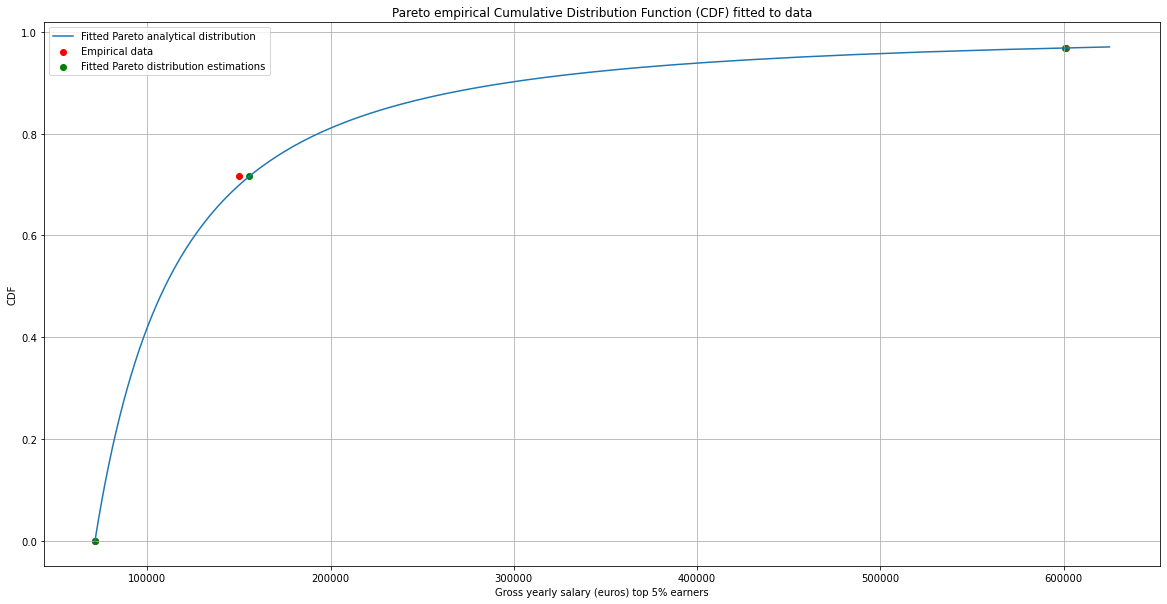

In [21]:
# Generate samples from the calculated distribution to make plots
q = np.arange(0, round(pareto_q[-1],3)+0.005, 0.005)
# docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pareto.html
x = stats.pareto.ppf(q, b=alpha2, scale=xm)
pareto_x_estimates = stats.pareto.ppf(pareto_q, b=alpha2, scale=xm)

fig = plt.figure(figsize=(20,10))
axes = plt.gca()

plt.scatter(pareto_x, pareto_q, color="red", label="Empirical data")
plt.scatter(pareto_x_estimates, pareto_q, color="green", label="Fitted Pareto distribution estimations")
plt.plot(x, q, label="Fitted Pareto analytical distribution")

plt.title('Pareto empirical Cumulative Distribution Function (CDF) fitted to data')
plt.grid()
plt.xlabel('Gross yearly salary (euros) top 5% earners')
plt.legend(loc="upper left")
plt.ylabel('CDF')
plt.show()

My combination of lognormal and Pareto distributions to model Spanish working people's income seems to effectively model the percentiles between p10 and p99.9. I model the percentiles between p10 and p97.5 using a lognormal distribution with a median equal to 22383€ and a standard deviation equal to 0.59. Then, I model the percentiles between p97.5 and p99.9 through a Pareto probability distribution with alpha = 1.617 and Xm = 71500€ (2022 data). 

In [22]:
_q = np.arange(0.975, 1, 0.0005)
qmapper = lambda p: (p - min_q)/pareto_range
_x = stats.pareto.ppf(qmapper(_q), b=alpha2, scale=xm)
df_pareto_cdf = pd.DataFrame(columns=["total_percentile","pareto_percentile","value_eur_2022"])
df_pareto_cdf["total_percentile"] = _q
df_pareto_cdf["pareto_percentile"] = qmapper(_q)
df_pareto_cdf["value_eur_2022"] = _x
# Spain 2023 inflation: 3.5%
# Spain 2024 inflation projected at 3% (approx)
df_pareto_cdf["value_eur_inflation_adjusted_to_2024"] = df_pareto_cdf["value_eur_2022"]*1.035*1.03

In [23]:
df_pareto_cdf

,total_percentile,pareto_percentile,value_eur_2022,value_eur_inflation_adjusted_to_2024
0,0.9750,0.00,7.150200e+04,7.622471e+04
1,0.9755,0.02,7.240066e+04,7.718272e+04
2,0.9760,0.04,7.332950e+04,7.817291e+04
3,0.9765,0.06,7.429018e+04,7.919705e+04
4,0.9770,0.08,7.528453e+04,8.025707e+04
5,0.9775,0.10,7.631448e+04,8.135506e+04
6,0.9780,0.12,7.738216e+04,8.249325e+04
7,0.9785,0.14,7.848983e+04,8.367408e+04
8,0.9790,0.16,7.963999e+04,8.490022e+04
9,0.9795,0.18,8.083534e+04,8.617452e+04


In [24]:
_tmp = pd.DataFrame()
_tmp["value_eur_2022"] = np.append(np.arange(1e5,1e6,1e5),np.arange(1e6,1e7,1e6))
_tmp["pareto_percentile"] = stats.pareto.cdf(_tmp["value_eur_2022"], b=alpha2, scale=xm)
inverse_mapper = lambda q : q*pareto_range + min_q
_tmp["total_percentile"] = inverse_mapper(_tmp["pareto_percentile"])
_tmp["value_eur_inflation_adjusted_to_2024"] = _tmp["value_eur_2022"]*1.035*1.03
_tmp

,value_eur_2022,pareto_percentile,total_percentile,value_eur_inflation_adjusted_to_2024
0,100000.0,0.418757,0.985469,106605.0
1,200000.0,0.810575,0.995264,213210.0
2,300000.0,0.901688,0.997542,319815.0
3,400000.0,0.938267,0.998457,426420.0
4,500000.0,0.956971,0.998924,533025.0
5,600000.0,0.967960,0.999199,639630.0
6,700000.0,0.975031,0.999376,746235.0
7,800000.0,0.979881,0.999497,852840.0
8,900000.0,0.983371,0.999584,959445.0
9,1000000.0,0.985977,0.999649,1066050.0


### Exporting CSV to Kaggle 
Data will be cleaned and translated to english where convinient before uploading to Kaggle: https://www.kaggle.com/jtljtl/spain-salary-distribution

In [25]:
data_aeat

{'pmf': array([0.2501, 0.101 , 0.2102, 0.1736, 0.2127, 0.0453, 0.0063]),
 'gross_income_euros': [6000, 12000, 21000, 30000, 60000, 150000, 601000],
 'cdf': array([0.2501, 0.3511, 0.5613, 0.7349, 0.9476, 0.9929, 0.9992])}

I will add to INE data the upper percentiles provided by AEAT:

In [26]:
_data_aeat = [
    ["both","nationwide","95rd_percentile",2022,60_000.0,0.9476],
    ["both","nationwide","99th_percentile",2022,150_000.0,0.9929],
    ["both","nationwide","99.9th_percentile",2022,601_000.0,0.9992]
]

df = df.append(pd.DataFrame(_data_aeat, columns=df.columns)).reset_index(drop=True)

In [27]:
df.tail(5)

,gender,state,statistic,year,gross_income_euros,percentile
4858,male,"Rioja, La",90th_percentile,2009,37994.40,0.9000
4859,male,"Rioja, La",90th_percentile,2008,37080.55,0.9000
4860,both,nationwide,95rd_percentile,2022,60000.00,0.9476
4861,both,nationwide,99th_percentile,2022,150000.00,0.9929
4862,both,nationwide,99.9th_percentile,2022,601000.00,0.9992


In [28]:
# This is the CSV that I uploaded to Kaggle
df[['year','state','gender','statistic','gross_income_euros']]\
    .to_csv('spain_salary_distribution_english.csv',encoding='utf-8',index=False)